In [2]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt

from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv2DTranspose, Conv2D, BatchNormalization, Activation)
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam

AUTOTUNE = tf.data.AUTOTUNE


In [3]:
# Define paths
image_dir = "/kaggle/input/pneumothorax-chest-xray-images-and-masks/siim-acr-pneumothorax/png_images"
mask_dir = "/kaggle/input/pneumothorax-chest-xray-images-and-masks/siim-acr-pneumothorax/png_masks"

# Load file names
image_paths = sorted([os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith('.png')])
mask_paths = sorted([os.path.join(mask_dir, f) for f in os.listdir(mask_dir) if f.endswith('.png')])

# Check if lengths match
assert len(image_paths) == len(mask_paths), "❌ Error: Number of images and masks do not match!"
print(f"✅ Total Images: {len(image_paths)}, Total Masks: {len(mask_paths)}")


✅ Total Images: 12047, Total Masks: 12047


In [4]:
def preprocess_image(image_path, mask_path):
    # Read image and mask
    image = cv2.imread(image_path)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    # Convert to RGB (cv2 loads images in BGR format)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Resize images and masks to 224x224
    image = cv2.resize(image, (224, 224)) / 255.0  # Normalize
    mask = cv2.resize(mask, (224, 224)) / 255.0    # Normalize

    # Expand mask dimensions (H, W, 1) for model compatibility
    mask = np.expand_dims(mask, axis=-1)

    return image, mask

# Verify preprocessing works
image, mask = preprocess_image(image_paths[0], mask_paths[0])
print(f"✅ Image Shape: {image.shape}, Mask Shape: {mask.shape}")


✅ Image Shape: (224, 224, 3), Mask Shape: (224, 224, 1)


In [5]:
def load_data(image_path, mask_path):
    image, mask = tf.numpy_function(preprocess_image, [image_path, mask_path], [tf.float32, tf.float32])
    image.set_shape([224, 224, 3])
    mask.set_shape([224, 224, 1])
    return image, mask

BATCH_SIZE = 16
train_dataset = tf.data.Dataset.from_tensor_slices((image_paths, mask_paths))
train_dataset = train_dataset.map(load_data, num_parallel_calls=AUTOTUNE)
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(AUTOTUNE)

print("✅ train_dataset successfully created!")


✅ train_dataset successfully created!


In [6]:
import tensorflow as tf
import cv2
import numpy as np

# Function to preprocess images
def preprocess_image(image_path, mask_path):
    # Convert Tensor to NumPy String
    image_path = image_path.numpy().decode("utf-8")
    mask_path = mask_path.numpy().decode("utf-8")

    # Read image and mask
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)  # Read image in RGB
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # Read mask in Grayscale

    # Ensure files are read properly
    if image is None:
        raise ValueError(f"❌ Failed to read image file: {image_path}")
    if mask is None:
        raise ValueError(f"❌ Failed to read mask file: {mask_path}")

    # Resize images and masks to (224, 224)
    image = cv2.resize(image, (224, 224)) / 255.0  # Normalize to [0,1]
    mask = cv2.resize(mask, (224, 224)) / 255.0  # Normalize

    # Expand mask dimensions (H, W, 1)
    mask = np.expand_dims(mask, axis=-1)

    return np.array(image, dtype=np.float32), np.array(mask, dtype=np.float32)

# Function to wrap it for TensorFlow Dataset
def preprocess_wrapper(image_path, mask_path):
    return tf.py_function(preprocess_image, [image_path, mask_path], [tf.float32, tf.float32])

# Convert lists to TensorFlow Dataset
BATCH_SIZE = 16
train_dataset = tf.data.Dataset.from_tensor_slices((image_paths, mask_paths))
train_dataset = train_dataset.map(preprocess_wrapper, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

print("✅ Dataset successfully loaded with proper preprocessing!")


✅ Dataset successfully loaded with proper preprocessing!


In [7]:
for img, msk in train_dataset.take(1):
    print(f"✅ Image batch shape: {img.shape}, Mask batch shape: {msk.shape}")
    

✅ Image batch shape: (16, 224, 224, 3), Mask batch shape: (16, 224, 224, 1)


In [8]:
# Define input
input_layer = Input(shape=(224, 224, 3))

# Load ResNet50 (pretrained, without top layers)
resnet = ResNet50(include_top=False, weights='imagenet', input_tensor=input_layer)

# Decoder (Upsampling Path)
conv2d_transpose_1 = Conv2DTranspose(256, (3, 3), strides=2, padding="same", activation="relu")(resnet.output)
conv2d_transpose_2 = Conv2DTranspose(128, (3, 3), strides=2, padding="same", activation="relu")(conv2d_transpose_1)
conv2d_transpose_3 = Conv2DTranspose(64, (3, 3), strides=2, padding="same", activation="relu")(conv2d_transpose_2)
conv2d_transpose_4 = Conv2DTranspose(32, (3, 3), strides=2, padding="same", activation="relu")(conv2d_transpose_3)

# Final Upsampling to Match Target Shape (224x224x1)
output_layer = Conv2DTranspose(1, (3, 3), strides=2, padding="same", activation="sigmoid")(conv2d_transpose_4)

# Define Model
model = Model(inputs=input_layer, outputs=output_layer)

print("✅ Model created successfully!")


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
✅ Model created successfully!


In [11]:
def load_image_and_mask(image_path, mask_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize(image, (224, 224))  # Resize to match model input
    image = tf.cast(image, tf.float32) / 255.0  # Normalize
    
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.image.resize(mask, (224, 224))  # Ensure mask has same shape
    mask = tf.cast(mask, tf.float32) / 255.0  # Normalize

    return image, mask

# Apply the function to the dataset
train_dataset = tf.data.Dataset.from_tensor_slices((train_image_paths, train_mask_paths))
train_dataset = train_dataset.map(load_image_and_mask).batch(16).prefetch(tf.data.AUTOTUNE)


In [10]:
import glob

# Load paths for all training images and masks
train_image_paths = sorted(glob.glob("/kaggle/input/pneumothorax-chest-xray-images-and-masks/siim-acr-pneumothorax/png_images/*.png"))  # Load all PNGs
train_mask_paths = sorted(glob.glob("/kaggle/input/pneumothorax-chest-xray-images-and-masks/siim-acr-pneumothorax/png_masks/*.png"))  # Load all PNGs

# Ensure the paths are loaded correctly
print(f"Found {len(train_image_paths)} training images.")  # Should be >1
print(f"Found {len(train_mask_paths)} training masks.")  # Should be >1

# Apply the function to create the dataset
train_dataset = tf.data.Dataset.from_tensor_slices((train_image_paths, train_mask_paths))
train_dataset = train_dataset.map(load_image_and_mask).batch(16).prefetch(tf.data.AUTOTUNE)


Found 12047 training images.
Found 12047 training masks.


In [12]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2DTranspose
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam

def create_model():
    # Define input layer
    input_layer = Input(shape=(224, 224, 3))

    # Load ResNet50 without top layers
    resnet = ResNet50(include_top=False, weights="imagenet", input_tensor=input_layer)

    # Decoder Path (Upsampling)
    x = Conv2DTranspose(256, (3, 3), strides=2, padding="same", activation="relu")(resnet.output)
    x = Conv2DTranspose(128, (3, 3), strides=2, padding="same", activation="relu")(x)
    x = Conv2DTranspose(64, (3, 3), strides=2, padding="same", activation="relu")(x)
    x = Conv2DTranspose(32, (3, 3), strides=2, padding="same", activation="relu")(x)

    # Final output layer with sigmoid activation
    output_layer = Conv2DTranspose(1, (3, 3), strides=2, padding="same", activation="sigmoid")(x)

    # Define and compile model
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer=Adam(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])
    
    return model  # ✅ Return model instead of defining globally

# ✅ Create model inside function
model = create_model()

# ✅ Ensure dataset is correct
for img, msk in train_dataset.take(1):
    print(f"✅ Image batch shape: {img.shape}, Mask batch shape: {msk.shape}")

# ✅ Train the model
EPOCHS = 10
history = model.fit(train_dataset, epochs=EPOCHS)

print("✅ Model training completed!")


✅ Image batch shape: (16, 224, 224, 3), Mask batch shape: (16, 224, 224, 1)
Epoch 1/10
753/753 ━━━━━━━━━━━━━━━━━━━━ 231s 225ms/step - accuracy: 0.9423 - loss: 0.1226
Epoch 2/10
753/753 ━━━━━━━━━━━━━━━━━━━━ 150s 199ms/step - accuracy: 0.9960 - loss: 0.0126
Epoch 3/10
753/753 ━━━━━━━━━━━━━━━━━━━━ 149s 198ms/step - accuracy: 0.9961 - loss: 0.0098
Epoch 4/10
753/753 ━━━━━━━━━━━━━━━━━━━━ 149s 198ms/step - accuracy: 0.9965 - loss: 0.0080
Epoch 5/10
753/753 ━━━━━━━━━━━━━━━━━━━━ 150s 198ms/step - accuracy: 0.9974 - loss: 0.0063
Epoch 7/10
753/753 ━━━━━━━━━━━━━━━━━━━━ 149s 198ms/step - accuracy: 0.9977 - loss: 0.0055
Epoch 8/10
753/753 ━━━━━━━━━━━━━━━━━━━━ 150s 199ms/step - accuracy: 0.9979 - loss: 0.0049
Epoch 9/10
753/753 ━━━━━━━━━━━━━━━━━━━━ 150s 199ms/step - accuracy: 0.9980 - loss: 0.0046
Epoch 10/10
753/753 ━━━━━━━━━━━━━━━━━━━━ 149s 198ms/step - accuracy: 0.9981 - loss: 0.0043
✅ Model training completed!


In [ ]:
# Print available variables
%whos  # (This will list all defined variables in your notebook)


In [13]:
from sklearn.model_selection import train_test_split


# 80% Training, 20% Validation
train_image_paths, val_image_paths, train_mask_paths, val_mask_paths = train_test_split(
    image_paths, mask_paths, test_size=0.2, random_state=42
)

print(f"✅ Train size: {len(train_image_paths)}, Validation size: {len(val_image_paths)}")


✅ Train size: 9637, Validation size: 2410


In [15]:
import tensorflow as tf
import cv2
import numpy as np

# Function to preprocess images
def preprocess_image(image_path):
    image = cv2.imread(image_path.numpy().decode("utf-8"))  # Read image
    image = cv2.resize(image, (224, 224))  # Resize
    image = image / 255.0  # Normalize
    return np.array(image, dtype=np.float32)  # Convert to float32

# Function to preprocess masks
def preprocess_mask(mask_path):
    mask = cv2.imread(mask_path.numpy().decode("utf-8"), cv2.IMREAD_GRAYSCALE)  # Read mask
    mask = cv2.resize(mask, (224, 224))  # Resize
    mask = mask / 255.0  # Normalize
    mask = np.expand_dims(mask, axis=-1)  # Ensure (224,224,1)
    return np.array(mask, dtype=np.float32)  # Convert to float32

# Function to load image & mask
def load_image_and_mask(image_path, mask_path):
    image = tf.py_function(preprocess_image, [image_path], tf.float32)
    mask = tf.py_function(preprocess_mask, [mask_path], tf.float32)

    # Explicitly set shapes
    image.set_shape((224, 224, 3))
    mask.set_shape((224, 224, 1))

    return image, mask


In [16]:
val_image_ds = tf.data.Dataset.from_tensor_slices(val_image_paths)
val_mask_ds = tf.data.Dataset.from_tensor_slices(val_mask_paths)

# Pair images and masks together
val_dataset = tf.data.Dataset.zip((val_image_ds, val_mask_ds))
val_dataset = val_dataset.map(load_image_and_mask)

# Batch and prefetch for performance
BATCH_SIZE = 16  # Same as training
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

print("✅ Validation dataset created successfully!")


✅ Validation dataset created successfully!


In [17]:
# Evaluate the model on validation set
loss, accuracy = model.evaluate(val_dataset)
print(f"✅ Validation Loss: {loss:.4f}, Validation Accuracy: {accuracy:.4f}")


151/151 ━━━━━━━━━━━━━━━━━━━━ 64s 399ms/step - accuracy: 0.9983 - loss: 0.0049
✅ Validation Loss: 0.0054, Validation Accuracy: 0.9982


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


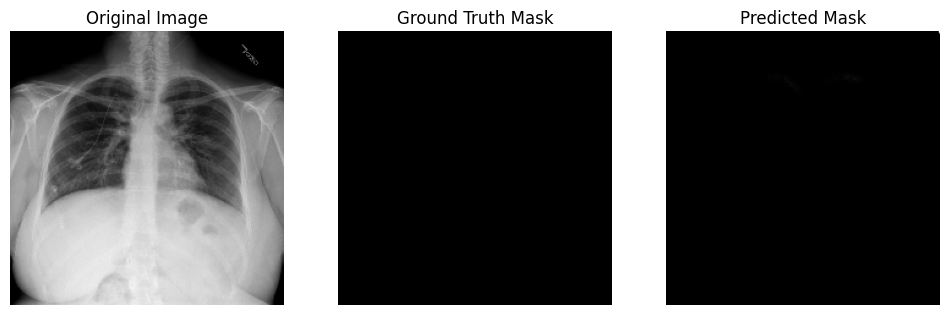

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


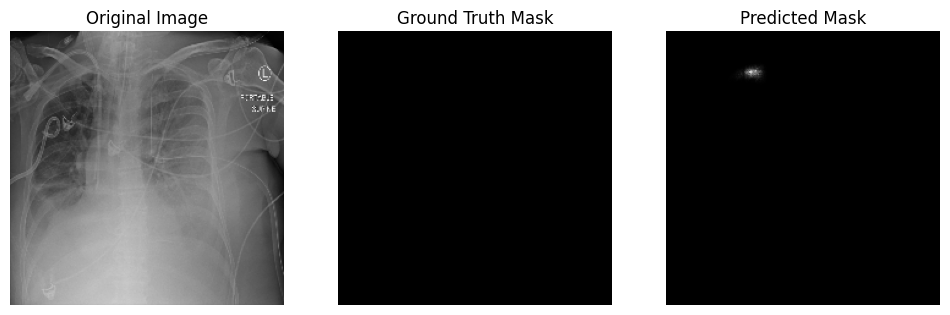

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


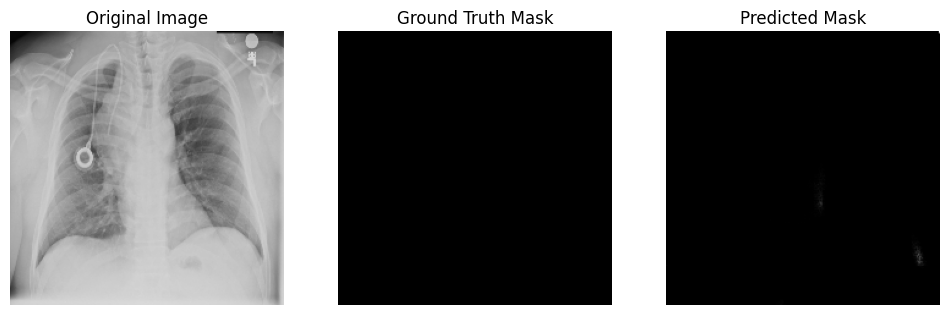

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


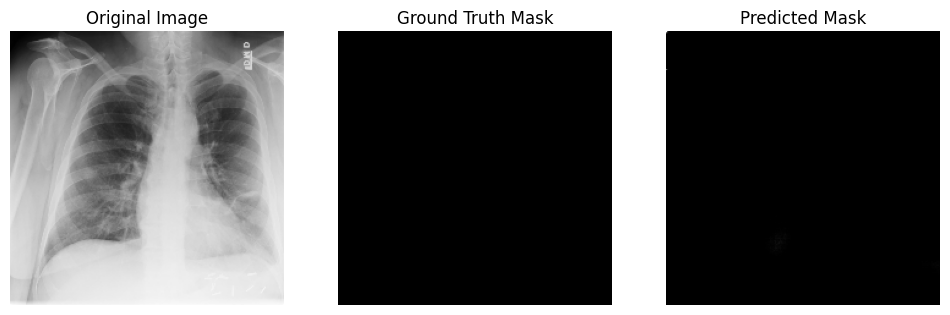

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


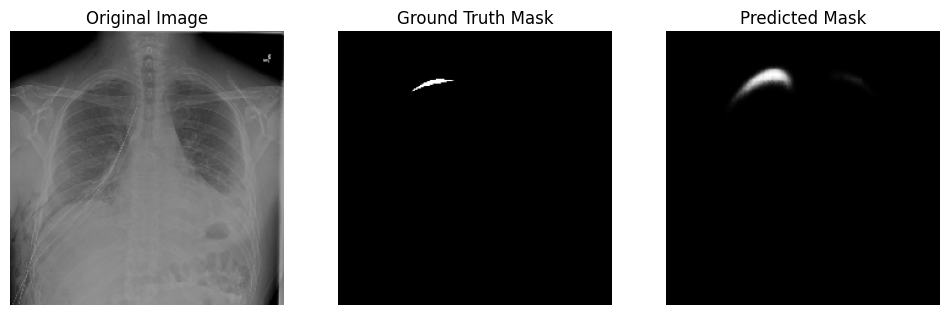

In [27]:
import matplotlib.pyplot as plt

# Get one image and mask from validation dataset
for img, mask in val_dataset.take(5):
    sample_img = img[1].numpy()  # Take first image
    sample_mask = mask[1].numpy()  # Take first mask

    # Make prediction
    pred_mask = model.predict(tf.expand_dims(sample_img, axis=0))[0]

    # Plot original image, ground truth mask, and predicted mask
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    axes[0].imshow(sample_img)
    axes[0].set_title("Original Image")
    axes[0].axis("off")

    axes[1].imshow(sample_mask[:, :, 0], cmap="gray")
    axes[1].set_title("Ground Truth Mask")
    axes[1].axis("off")

    axes[2].imshow(pred_mask[:, :, 0], cmap="gray")
    axes[2].set_title("Predicted Mask")
    axes[2].axis("off")

    plt.show()
     # Stop after one sample


In [28]:
pip install lime


Note: you may need to restart the kernel to use updated packages.


In [29]:
import numpy as np
import cv2
import tensorflow as tf
from lime.lime_image import LimeImageExplainer

# Load the sample image
image_path = "/kaggle/input/pneumothorax-chest-xray-images-and-masks/siim-acr-pneumothorax/png_images/0_train_0_.png"  # Change this to an actual image path
sample_img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Load in grayscale
sample_img = cv2.resize(sample_img, (224, 224))  # Resize to match model input
sample_img = sample_img / 255.0  # Normalize to [0,1]
sample_img = np.expand_dims(sample_img, axis=-1)  # Add channel dimension (224, 224, 1)
sample_img = np.expand_dims(sample_img, axis=0)  # Add batch dimension (1, 224, 224, 1)

print(f"Sample image shape: {sample_img.shape}")  # Should be (1, 224, 224, 1)


Sample image shape: (1, 224, 224, 1)


In [30]:
def predict_fn(images):
    preds = model.predict(images)  # Model prediction
    preds = preds.mean(axis=(1, 2, 3))  # Collapse spatial dimensions
    preds = np.expand_dims(preds, axis=1)  # Ensure shape (batch_size, 1)
    return preds


In [31]:
import numpy as np
import tensorflow as tf

# ✅ Ensure dataset exists
for sample_img, sample_mask in train_dataset.take(1):  # Take one sample
    sample_img_rgb = sample_img.numpy()  # Convert to NumPy
    break  # Ensure only one sample is taken

# ✅ Ensure `sample_img_rgb` has shape (H, W, C)
if 'sample_img_rgb' in locals():  # Check if defined
    sample_img_rgb = np.squeeze(sample_img_rgb)  # Remove extra batch dim if present
    print("✅ sample_img_rgb shape:", sample_img_rgb.shape)
else:
    print("⚠️ ERROR: sample_img_rgb is not defined!")


✅ sample_img_rgb shape: (16, 224, 224, 3)


In [32]:
# Ensure sample_img_rgb has shape (H, W, C)
sample_img_rgb = np.squeeze(sample_img_rgb)  # Remove extra batch dim if present


In [33]:
sample_img_rgb = sample_img_rgb[0]  # Select the first image
print(sample_img_rgb.shape)  # Should now be (224, 224, 3)


(224, 224, 3)


In [34]:
import numpy as np
sample_img_rgb = np.array(sample_img_rgb)


In [35]:
from lime import lime_image
import numpy as np

# ✅ Define the LIME Explainer
explainer = lime_image.LimeImageExplainer()

# ✅ Ensure classifier function is defined
def classifier_fn(images):
    preds = model.predict(images)  # Get predictions
    return preds.reshape((preds.shape[0], -1))  # Ensure correct shape

# ✅ Ensure `sample_img_rgb` exists
if 'sample_img_rgb' not in locals():
    raise ValueError("⚠️ ERROR: `sample_img_rgb` is not defined!")

# ✅ Run LIME explanation
explanation = explainer.explain_instance(
    sample_img_rgb,  # ✅ Make sure it's correctly formatted
    classifier_fn,  
    top_labels=1,
    hide_color=0,
    num_samples=1000
)

print("✅ LIME explanation completed!")


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━

In [36]:
# If grayscale, convert to RGB
if sample_img_rgb.shape[-1] == 1:
    sample_img_rgb = np.repeat(sample_img_rgb, 3, axis=-1)  # Convert to RGB


In [37]:
def classifier_fn(images):
    preds = model.predict(images)  # Get predictions
    preds = preds.reshape((preds.shape[0], -1))  # Reshape to (num_samples, num_classes)
    return preds


In [38]:
# Ensure the image is 3D (H, W, C) and RGB
if sample_img_rgb.ndim == 2:
    sample_img_rgb = np.stack([sample_img_rgb] * 3, axis=-1)  # Convert grayscale to RGB
elif sample_img_rgb.shape[-1] == 1:
    sample_img_rgb = np.repeat(sample_img_rgb, 3, axis=-1)  # Convert single channel to RGB

# Remove extra batch dimensions if present
sample_img_rgb = np.squeeze(sample_img_rgb)  # Remove batch dimension if any


In [ ]:
pip install lime


In [39]:
import lime
from lime import lime_image
import numpy as np
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━

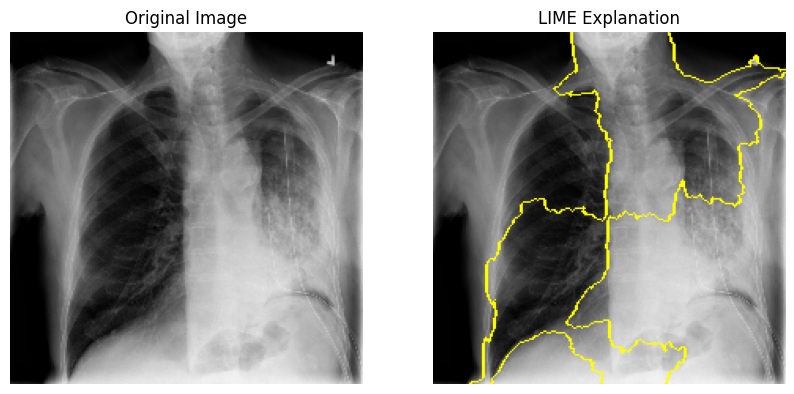

In [40]:
# Create LIME explainer
explainer = lime.lime_image.LimeImageExplainer()

# Run explanation with fixed classifier function
explanation = explainer.explain_instance(
    sample_img_rgb,  # Ensure input is (H, W, 3)
    classifier_fn,    # Use the fixed classifier function
    top_labels=1,
    hide_color=0,
    num_samples=1000  # You can increase this if needed
)

# Get the image explanation mask
temp, mask = explanation.get_image_and_mask(
    explanation.top_labels[0], positive_only=True, num_features=10, hide_rest=False
)

# Plot original image and LIME explanation
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(sample_img_rgb)  # Make sure this is in RGB format
axes[0].set_title("Original Image")
axes[0].axis("off")

axes[1].imshow(mark_boundaries(temp, mask))
axes[1].set_title("LIME Explanation")
axes[1].axis("off")

plt.show()


In [42]:
pip install torch torchvision torchaudio


Note: you may need to restart the kernel to use updated packages.


In [ ]:
import torch

# Save the model in Kaggle's working directory
save_path = "/kaggle/working/model.pth"

torch.save(model.state_dict(), save_path)

print(f"Model saved at {save_path}")


In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models

class PneumothoraxModel(nn.Module):
    def __init__(self):
        super(PneumothoraxModel, self).__init__()
        self.resnet = models.resnet18(pretrained=False)
        in_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(in_features, 1)  # Binary classification

    def forward(self, x):
        return self.resnet(x)

# Load the trained model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = PneumothoraxModel().to(device)

# ✅ Fix: Ensure correct loading
model.load_state_dict(torch.load("/content/model.pth", map_location=device), strict=True)
model.eval()


In [ ]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os
import pandas as pd


In [ ]:
class PneumothoraxDataset(Dataset):
    def __init__(self, csv_file, img_dir, mask_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = self.data.iloc[idx, 0] + ".png"  # Image name from CSV
        img_path = os.path.join(self.img_dir, img_name)
        mask_path = os.path.join(self.mask_dir, img_name)

        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")  # Convert to grayscale

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask


In [ ]:
import pandas as pd

csv_path = "/kaggle/input/pneumothorax-chest-xray-images-and-masks/siim-acr-pneumothorax/stage_1_train_images.csv"
df = pd.read_csv(csv_path)

print(df.head())  # Check first few rows


In [ ]:
class PneumothoraxDataset(Dataset):
    def __init__(self, csv_file, img_dir, mask_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = str(self.data.iloc[idx, 0])  # Ensure string
        if not img_name.endswith(".png"):       # Prevent double extension
            img_name += ".png"

        img_path = os.path.join(self.img_dir, img_name)
        mask_path = os.path.join(self.mask_dir, img_name)

        if not os.path.exists(img_path):
            print(f"Image not found: {img_path}")  # Debugging step

        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask


In [ ]:
import os

image_dir = "/kaggle/input/pneumothorax-chest-xray-images-and-masks/siim-acr-pneumothorax/png_images"
sample_images = os.listdir(image_dir)[:10]  # List first 10 files

print("Sample images in directory:", sample_images)


In [ ]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

train_dataset = PneumothoraxDataset(
    csv_file="/kaggle/input/pneumothorax-chest-xray-images-and-masks/siim-acr-pneumothorax/stage_1_train_images.csv",
    img_dir="/kaggle/input/pneumothorax-chest-xray-images-and-masks/siim-acr-pneumothorax/png_images",
    mask_dir="/kaggle/input/pneumothorax-chest-xray-images-and-masks/siim-acr-pneumothorax/png_masks",
    transform=transform
)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)

# Test loading
images, masks = next(iter(train_loader))
print("✅ Image batch shape:", images.shape)
print("✅ Mask batch shape:", masks.shape)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet18, ResNet18_Weights

# Load ResNet with proper weights
model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
model.fc = nn.Linear(512, 1)  # Adjust final layer for binary classification
model = model.cuda()

# Define loss and optimizer
criterion = nn.BCEWithLogitsLoss()  # Use BCEWithLogitsLoss for binary classification
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training loop
# Training loop
model.train()
for images, masks in train_loader:
    images = images.cuda()
    
    # Convert masks to binary labels
    masks = (masks.max(dim=2)[0].max(dim=2)[0]).float().cuda()

    optimizer.zero_grad()
    outputs = model(images)  # Keep shape as [batch_size, 1]
    
    loss = criterion(outputs, masks.view(-1, 1))  # Ensure shape [batch_size, 1]
    loss.backward()
    optimizer.step()



In [ ]:
import torch.nn as nn
import torchvision.models as models

class PneumothoraxResNet(nn.Module):
    def __init__(self):
        super(PneumothoraxResNet, self).__init__()
        base_model = models.resnet34(weights=models.ResNet34_Weights.DEFAULT)  # Load pretrained ResNet34
        self.base_layers = nn.Sequential(*list(base_model.children())[:-2])  # Remove FC layer
        
        self.conv1x1 = nn.Conv2d(in_channels=512, out_channels=1, kernel_size=1)  # 1x1 Conv for segmentation
        
        # ✅ Updated upsampling to ensure 256x256 output
        self.upsample = nn.Sequential(
            nn.ConvTranspose2d(1, 1, kernel_size=4, stride=2, padding=1),  # Upsample 8x8 -> 16x16
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(1, 1, kernel_size=4, stride=2, padding=1),  # 16x16 -> 32x32
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(1, 1, kernel_size=4, stride=2, padding=1),  # 32x32 -> 64x64
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(1, 1, kernel_size=4, stride=2, padding=1),  # 64x64 -> 128x128
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(1, 1, kernel_size=4, stride=2, padding=1),  # 128x128 -> 256x256
        )

    def forward(self, x):
        x = self.base_layers(x)  # Shape: [batch_size, 512, 8, 8]
        x = self.conv1x1(x)      # Shape: [batch_size, 1, 8, 8]
        x = self.upsample(x)     # ✅ Now correctly upscales to [batch_size, 1, 256, 256]
        return x


In [ ]:
model = PneumothoraxResNet().cuda()
dummy_input = torch.randn(16, 3, 256, 256).cuda()  # Batch of 16 images
output = model(dummy_input)
print("Model output shape:", output.shape)  # Expected: [16, 1, 256, 256]


In [ ]:
for images, masks in train_loader:
    images = images.cuda()  # Shape: [batch_size, 3, 256, 256]
    masks = masks.cuda()    # Shape: [batch_size, 1, 256, 256]

    optimizer.zero_grad()
    outputs = model(images)  # ✅ Model now outputs: [batch_size, 1, 256, 256]

    # ✅ No need to reshape, shapes now match correctly
    assert outputs.shape == masks.shape, f"Shape mismatch: {outputs.shape} vs {masks.shape}"

    loss = criterion(outputs, masks)  # Compute pixel-wise loss
    loss.backward()
    optimizer.step()


In [ ]:
import torch

# Ensure model, optimizer, and loss function are defined
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)  # Move model to GPU if available

num_epochs = 10  # Set number of training epochs

for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0  
    correct_pixels = 0
    total_pixels = 0

    for images, masks in train_loader:
        images = images.to(device)
        masks = masks.to(device).float()  # Ensure masks are float (for BCEWithLogitsLoss)

        optimizer.zero_grad()
        outputs = model(images)  # Model prediction (logits, no sigmoid)

        loss = criterion(outputs, masks)  # Compute loss
        loss.backward()

        # 🚨 **Check if gradients are updating** 🚨
        total_grad = sum(p.grad.abs().sum().item() for p in model.parameters() if p.grad is not None)
        if total_grad == 0:
            print(f"⚠️ Epoch {epoch+1}: Warning! No gradient update detected!")

        optimizer.step()

        running_loss += loss.item()

        # **Compute Accuracy**
        predicted_masks = torch.sigmoid(outputs) > 0.5  # Convert logits to binary mask
        correct_pixels += (predicted_masks == masks.bool()).sum().item()
        total_pixels += masks.numel()

    avg_loss = running_loss / len(train_loader)
    accuracy = correct_pixels / total_pixels * 100

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.6f}, Accuracy: {accuracy:.2f}%")

print("Training complete! ✅")


In [ ]:
torch.save(model.state_dict(), "pneumothorax_resnet.pth")
